In [ ]:
## Script that estimates the thicknesses of the thin DSSSDs
# The angle files are calculated from the angle_effect script.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:

datapath = "/home/haue/repositories/Masters/data/bananas/Si"
iso = "Si" 
simpath = "/home/haue/repositories/Masters/simdata/"
datafiles = glob.glob(os.path.join(datapath, "*mlio.root"))


In [3]:
#Limits defined from implantation_analysis folder and Si_Banana_explorer script
ls = np.array([3.96, 3.95, 3.95, 1, 1, 3.92])*1e3
us = np.array([4.17, 4.14, 4.14, 1, 1, 4.14])*1e3

U1_fEdep = np.array([])
for batch in uproot.iterate(datafiles, expressions=["fEdep"],
    cut=f"(E>{ls[0]}) & (E<{us[0]}) & (id==0)"):
    U1_fEdep = np.append(U1_fEdep, ak.flatten(batch.fEdep))

U2_fEdep = np.array([])
for batch in uproot.iterate(datafiles, expressions=["fEdep"],
    cut=f"(E>{ls[1]}) & (E<{us[1]}) & (id==1)"):
    U2_fEdep = np.append(U2_fEdep, ak.flatten(batch.fEdep))

U3_fEdep = np.array([])
for batch in uproot.iterate(datafiles, expressions=["fEdep"],
    cut=f"(E>{ls[2]}) & (E<{us[2]}) & (id==2)"):
    U3_fEdep = np.append(U3_fEdep, ak.flatten(batch.fEdep))
    
U6_fEdep = np.array([])
for batch in uproot.iterate(datafiles, expressions=["fEdep"],
    cut=f"(E>{ls[5]}) & (E<{us[5]}) & (id==5)"):
    U6_fEdep = np.append(U6_fEdep, ak.flatten(batch.fEdep))

In [4]:
####Peak energies to be used in TRIM simulations
filename = simpath+"realsipeaksEE.dat"
#filename = simpath+"RealPeakESi.dat"
data = {}
current_detector = None
current_section = None

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith("# Detector="):
            parts = line.split()
            detector = parts[1].split('=')[1]
            section = parts[2]  # "FRONT" or "BACK"
            current_detector = detector
            current_section = section
            if detector not in data:
                data[detector] = {'front': [], 'back': []}
        elif line and not line.startswith("#"):
            try:
                value = float(line.split()[0])
                data[current_detector][current_section].append(value)
            except (ValueError, IndexError):
                continue  # Skip malformed lines

# Now compute the mean of FRONT + BACK for each detector
result = {}
for det, sections in data.items():
    all_values = sections['front'] + sections['back']
    mean_value = np.mean(all_values)
    result[det] = mean_value

# Print the results
for det, mean_val in result.items():
    print(f"{det}: mean energy = {mean_val:.2f} keV")
#result["U1"]
#PREV RES
#U1: mean energy = 4086.92 keV
#U2: mean energy = 4083.32 keV
#U3: mean energy = 4083.59 keV
#U6: mean energy = 4074.30 keV

U1: mean energy = 4086.90 keV
U2: mean energy = 4083.49 keV
U3: mean energy = 4083.49 keV
U6: mean energy = 4083.09 keV


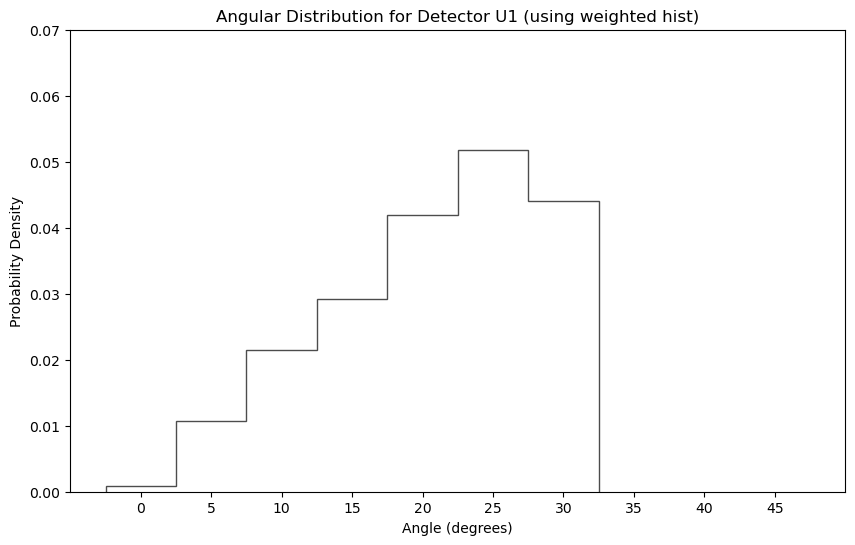

In [ ]:
### Scaling arrays to be used to compare TRIM to actual data
detectors = ['U1', 'U2', 'U3', 'U6']
histograms = {}
bin_edges = np.arange(-2.5, 32.5 + 5, 5)

for det in detectors:
    angs = np.loadtxt(f"{simpath}{det}angles.dat", unpack=True)
    counts, _ = np.histogram(angs, bins=bin_edges, density=True)
    
    histograms[det] = counts
### Scaling arrays to be used to compare TRIM to actual data
heights = histograms["U1"]

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(10, 6))
plt.hist(bin_centers, bins=bin_edges, weights=heights, edgecolor='k', histtype='step', alpha=0.7)
plt.xticks(np.arange(0,50,5))
plt.yticks(np.arange(0, 0.07, 0.01))
plt.xlim(-5,50)
plt.title("Angular Distribution for Detector U1 (using weighted hist)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Probability Density")
plt.show()


In [15]:
#### U1
 
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"TRIM/"
gn = ["U153_","U154_"]
txt = ".txt"
A = ["0", "5","10","15", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
    Es.append([4.087-np.array(i)*1e-6 for i in energies_eV]) 
#Es

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

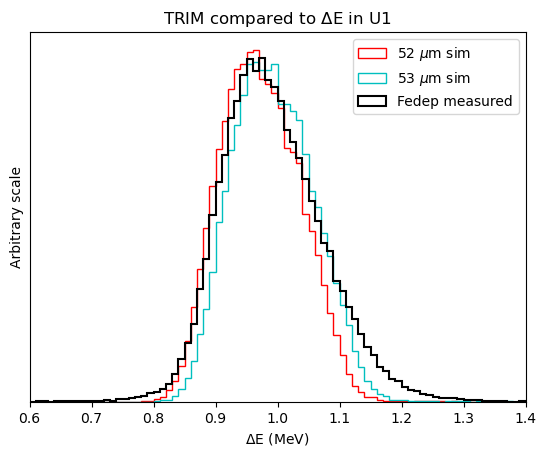

In [22]:
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(0.7, 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),histograms["U1"]):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.7,2, 0.01))
        maxval = np.max(histograms["U1"])
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        #plt.vlines(0.914*0.93, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    #plt.xlim(0.6,1.4)
    tots.append(total_hist)
    #plt.xlabel(r"$\Delta$E (MeV)")
    #plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.22
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"52 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='c', label=r"53 $\mu$m sim")
plt.hist(U1_fEdep/1e3, bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)

plt.xlim(0.6,1.4)
plt.title(r"TRIM compared to $\Delta$E in U1")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.yticks([])
plt.ylabel("Arbitrary scale")

plt.show()


In [8]:
#### U2
 
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"TRIM/"
gn = ["U268_","U269_"]
txt = ".txt"
A = ["0", "5","10","15", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
    Es.append([4.08332-np.array(i)*1e-6 for i in energies_eV]) 
#Es

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

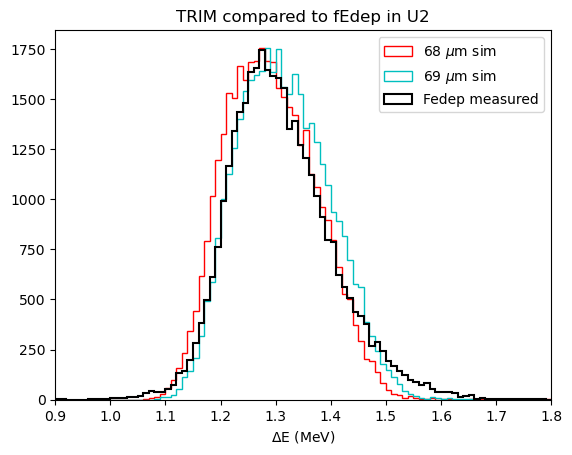

In [9]:
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(1, 2.5, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),histograms["U2"]):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(1,2.5, 0.01))
        maxval = np.max(histograms["U2"])
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        #plt.vlines(0.914*0.93, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    #plt.xlim(0.6,1.4)
    tots.append(total_hist)
    #plt.xlabel(r"$\Delta$E (MeV)")
    #plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(1, 2.5, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.1
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"68 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='c', label=r"69 $\mu$m sim")
plt.hist(U2_fEdep/1e3, bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)

plt.xlim(0.9,1.8)
plt.title(r"TRIM compared to fEdep in U2")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.show()


In [23]:
#### U3
 
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"TRIM/"
gn = ["U358_", "U359_"]
txt = ".txt"
A = ["0", "5","10","15", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
    Es.append([4.08356-np.array(i)*1e-6 for i in energies_eV]) 
#Es

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

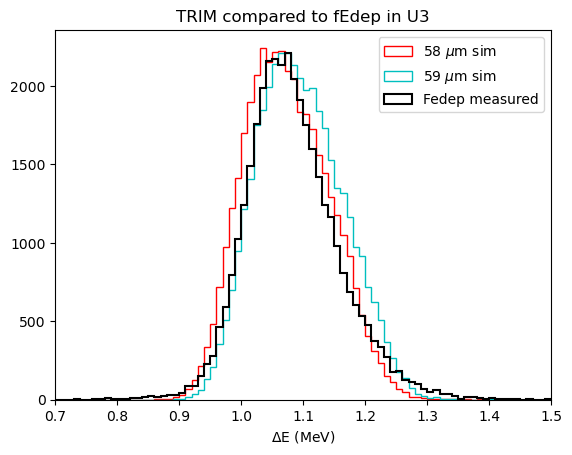

In [11]:
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(0.1, 2.5, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),histograms["U3"]):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.1,2.5, 0.01))
        maxval = np.max(histograms["U3"])
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        #plt.vlines(0.914*0.93, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    #plt.xlim(0.6,1.4)
    tots.append(total_hist)
    #plt.xlabel(r"$\Delta$E (MeV)")
    #plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(0.1, 2.5, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.02
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"58 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='c', label=r"59 $\mu$m sim")
plt.hist(U3_fEdep/1e3, bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)

plt.xlim(0.7,1.5)
plt.title(r"TRIM compared to fEdep in U3")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.show()


In [12]:
#### U6
 
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"TRIM/"
gn = ["U667_","U668_", "U269_"]
txt = ".txt"
A = ["0", "5","10","15", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
    Es.append([4.08309-np.array(i)*1e-6 for i in energies_eV]) 
#Es

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

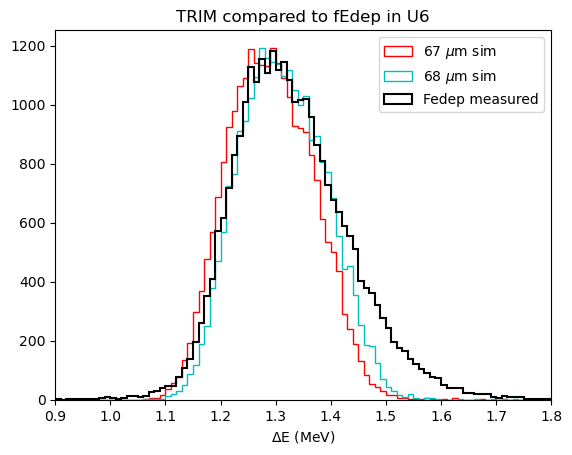

In [13]:
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(0.1, 2.5, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),histograms["U6"]):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.1,2.5, 0.01))
        maxval = np.max(histograms["U6"])
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        #plt.vlines(0.914*0.93, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    #plt.xlim(0.6,1.4)
    tots.append(total_hist)
    #plt.xlabel(r"$\Delta$E (MeV)")
    #plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(0.1, 2.5, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 1.52
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"67 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='c', label=r"68 $\mu$m sim")
#plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='c', label=r"69 $\mu$m sim")
plt.hist(U6_fEdep/1e3, bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)

plt.xlim(0.9,1.8)
plt.title(r"TRIM compared to fEdep in U6")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.show()
